#  Vanilla Untrained Model
This notebook is designed as a easy einterface to call the functions that we have defined

In [18]:
%load_ext autoreload
%autoreload 2

import torch
from LCModels import LCNECortexFCN, LCNECortexRNN, LCNECortexFitter, PupilDilationPredictor
from simulate import run_simulation, render_plot, run_trained_fitter_simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's defined the two types of models that we have first

In [2]:
lambda_cortex = 0.1 # LC-to-Cortex modulation strength
hidden_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_FCN = LCNECortexFCN(lambda_cortex).to(device)
model_RNN = LCNECortexRNN(hidden_size).to(device)

Then let's setup the simulation constants we want

In [3]:
time_steps = 100
conditions = ["baseline", "acute_stress", "chronic_stress", "top_down_control"]

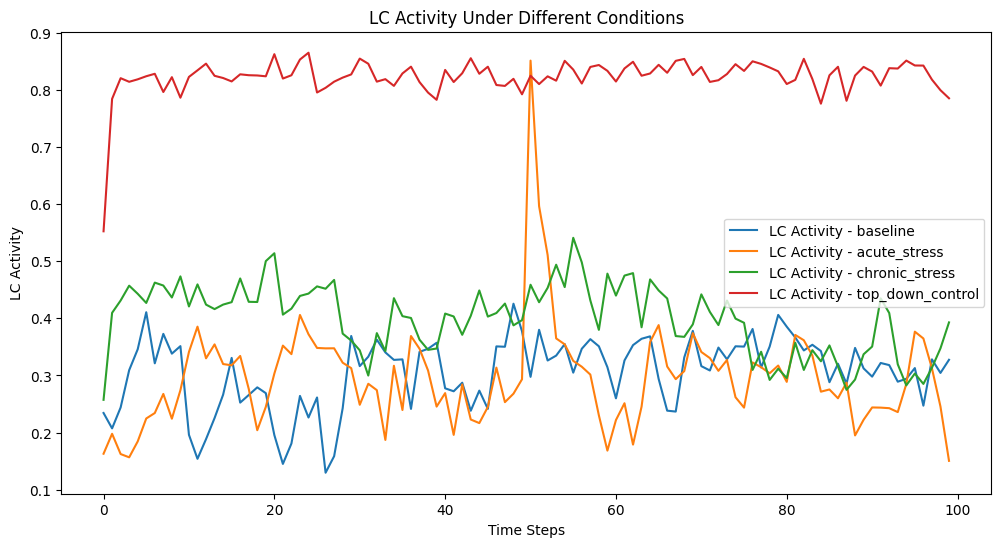

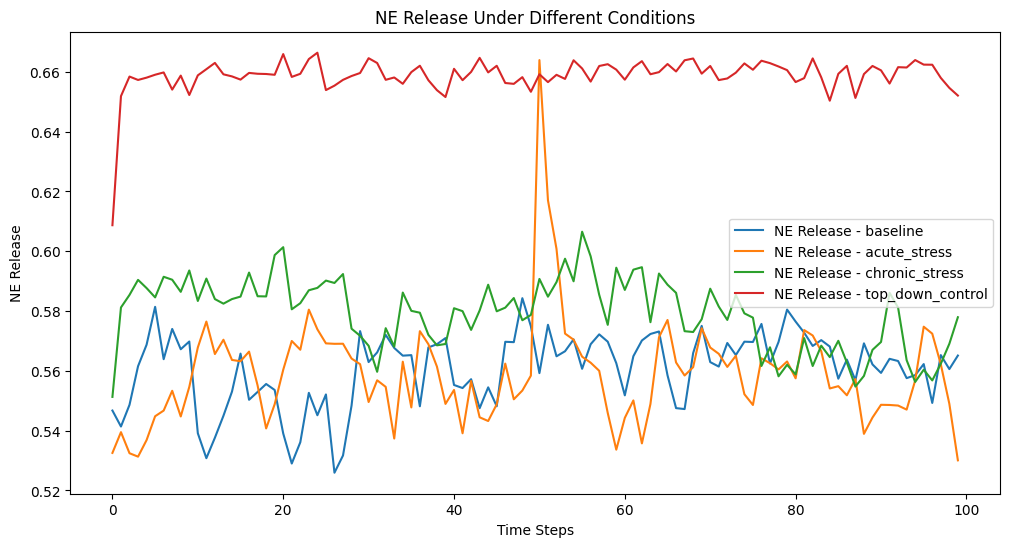

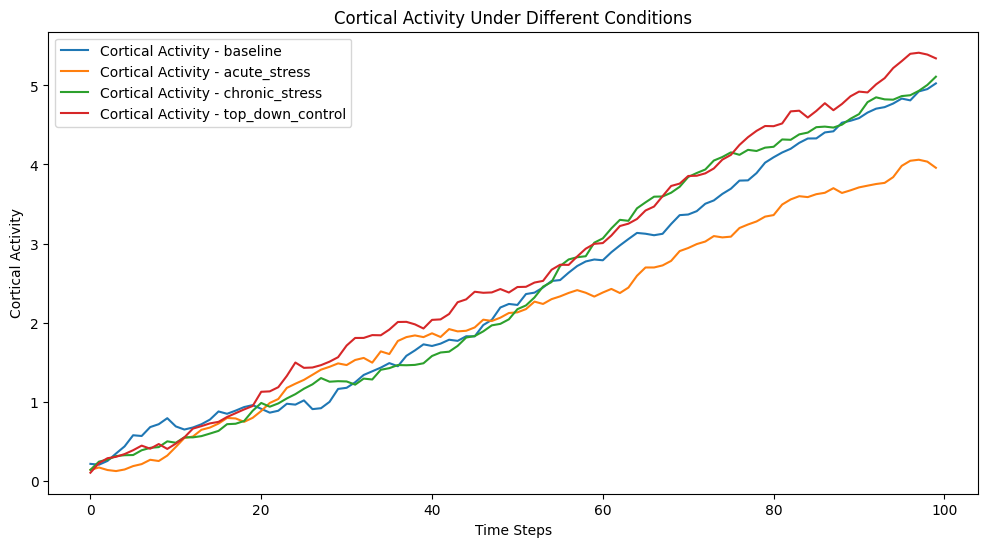

In [4]:
results = {cond: run_simulation(model_FCN, device, time_steps, cond) for cond in conditions}
render_plot(results)

In [5]:
# results = {cond: run_simulation(model_RNN, device, time_steps, cond) for cond in conditions}
# render_plot(results)

# Training & Fitting Models

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import torch.optim as optim
import torch.nn as nn
from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data

In [7]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

In [8]:
df_behavior['Event_PupilDilation'].describe()

count    1700.000000
mean        1.931902
std         3.270228
min        -8.299500
25%        -0.345355
50%         1.011750
75%         3.296925
max        17.457000
Name: Event_PupilDilation, dtype: float64

In [9]:
features = ['Condition', 'PreEvent_PupilMax', 'TrialEvent', 'onset', 'duration']
target = ['Event_PupilDilation']

df_clean = df_behavior[features + target].dropna().reset_index(drop=True)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_clean[['Condition', 'TrialEvent']])
encoded_feature_names = encoder.get_feature_names_out(['Condition', 'TrialEvent'])

scaler_X = StandardScaler()
scaled_features = scaler_X.fit_transform(df_clean[['PreEvent_PupilMax', 'onset', 'duration']])

X_scaled = pd.DataFrame(scaled_features, columns=['PreEvent_PupilMax', 'onset', 'duration'])
X_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)

X_scaled.reset_index(drop=True, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)
X = pd.concat([X_scaled, X_encoded], axis=1)

# scaler_Y = StandardScaler()
# Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1,1))

scaler_Y = MinMaxScaler(feature_range=(-1, 1))
Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1, 1))

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).squeeze()

print(f"X Shape: {X_tensor.shape}, Y Shape: {Y_tensor.shape}")
print(f"Y Min: {Y_tensor.min().item()}, Y Max: {Y_tensor.max().item()}")  # Check Scaling

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


In [10]:
# Initialize model
model = LCNECortexFitter()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50)
loss_fn = nn.MSELoss()

epochs = 600
batch_size = 64
num_batches = X_tensor.shape[0] // batch_size

# Training Loop
for epoch in range(epochs):
    epoch_loss = 0.0

    for i in range(num_batches):
        optimizer.zero_grad()

        # Select batch
        start = i * batch_size
        end = start + batch_size

        X_batch = X_tensor[start:end, :]
        Y_batch = Y_tensor[start:end]

        # Initialize LC and Cortex states (batch_size,)
        prev_LC = torch.zeros(batch_size)
        prev_Cortex = torch.zeros(batch_size)

        # Forward pass
        LC_pred, NE_pred, C_pred, Pupil_pred = model(X_batch, prev_LC, prev_Cortex)

        # Compute loss
        loss = loss_fn(Pupil_pred, Y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Adjust learning rate
    scheduler.step(epoch_loss / num_batches)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / num_batches:.4f}, LR: {optimizer.param_groups[0]['lr']}")


Epoch 0, Loss: 0.2631, LR: 0.02
Epoch 100, Loss: 0.0616, LR: 0.02
Epoch 200, Loss: 0.0615, LR: 0.02
Epoch 300, Loss: 0.0609, LR: 0.005
Epoch 400, Loss: 0.0607, LR: 0.00125
Epoch 500, Loss: 0.0607, LR: 0.0003125


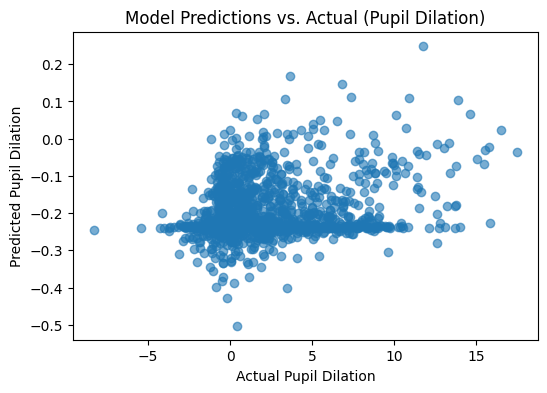

In [11]:
prev_LC = torch.zeros(X_tensor.shape[0])  
prev_Cortex = torch.zeros(X_tensor.shape[0])

with torch.no_grad():
    _, _, _, Pupil_pred = model(X_tensor, prev_LC, prev_Cortex)

df_predictions = pd.DataFrame({'PupilPred': Pupil_pred.detach().cpu().numpy()})

df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6)
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("Model Predictions vs. Actual (Pupil Dilation)")
plt.show()


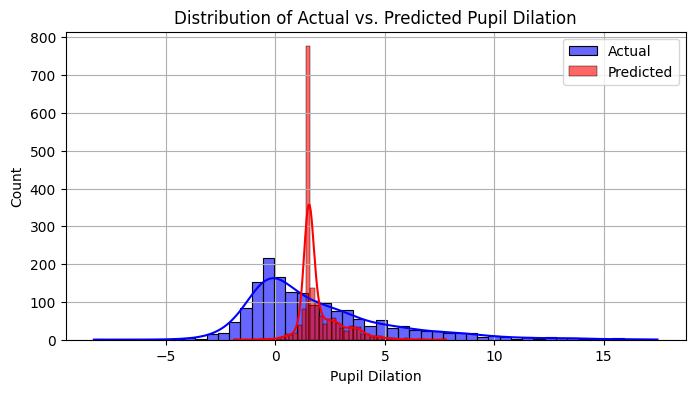

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df_predictions['PupilPred'] = scaler_Y.inverse_transform(df_predictions[['PupilPred']])

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation")
plt.grid(True)

plt.show()


In [13]:
from scipy.stats import pearsonr

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

Pearson Correlation: 0.2518


Epoch 0, Loss: 0.09813540428876877
Epoch 100, Loss: 0.04697606340050697
Epoch 200, Loss: 0.04564840719103813
Epoch 300, Loss: 0.044080834835767746
Epoch 400, Loss: 0.04299883916974068
Epoch 500, Loss: 0.04227454960346222
Epoch 600, Loss: 0.04115850105881691
Epoch 700, Loss: 0.040534909814596176
Epoch 800, Loss: 0.040257882326841354
Epoch 900, Loss: 0.0391988679766655


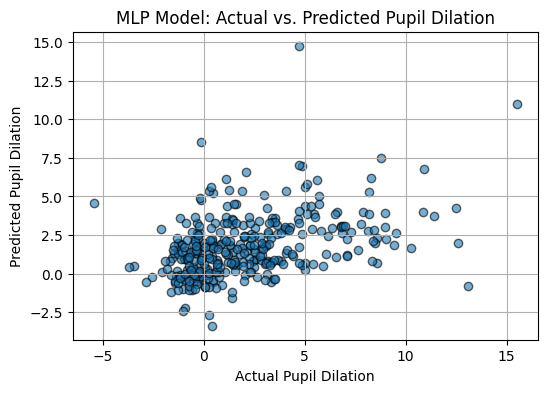

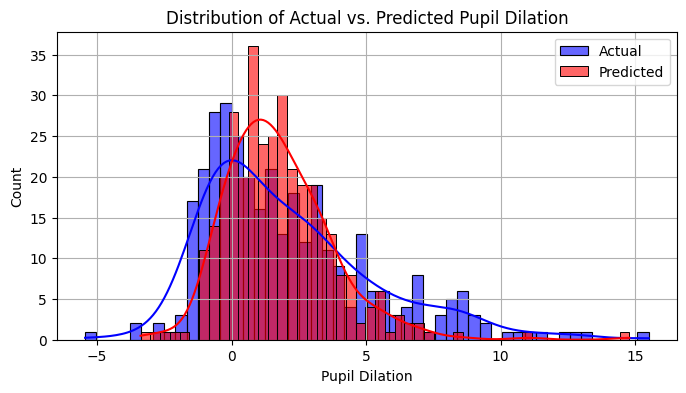

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

input_size = X_tensor.shape[1]
model = PupilDilationPredictor(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_train)
    loss = loss_fn(Y_pred, Y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

with torch.no_grad():
    Y_test_pred = model(X_test)

Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.cpu().numpy())
Y_test_actual = scaler_Y.inverse_transform(Y_test.cpu().numpy().reshape(-1, 1))

# Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(6, 4))
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("MLP Model: Actual vs. Predicted Pupil Dilation")
plt.grid(True)
plt.show()

# Convert predictions to DataFrame for visualization
df_predictions = pd.DataFrame({'PupilPred': Y_test_pred.flatten()})
df_actual = pd.DataFrame({'Event_PupilDilation': Y_test_actual.flatten()})

# Histogram: Distribution of Actual vs. Predicted
plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation")
plt.grid(True)
plt.show()

In [20]:
corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

Pearson Correlation: 0.4184
